In [2]:
# -------------------- General Purpose --------------------
import os
import math
import string
import random
import csv
import re
import collections
from collections import defaultdict, Counter

# -------------------- Data Handling --------------------
import numpy as np
import pandas as pd
from numpy.linalg import norm

# -------------------- Visualization --------------------
import matplotlib.pyplot as plt

# -------------------- NLP Preprocessing (Task 1, 2, 3) --------------------
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# -------------------- Word Embeddings (Task 2, 3, 4) --------------------
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence

# -------------------- XGBoost / LambdaMART (Task 3) --------------------
import xgboost as xgb
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler

# -------------------- PyTorch (Task 4: Neural Networks) --------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable


# Data preprocessing on train_data and validation_data

In [3]:
train_data = pd.read_csv('train_data.tsv', sep='\t',header=0,low_memory=False)
train_data  # 4364339 rows × 5 columns

,qid,pid,queries,passage,relevancy
0,188714,1000052,foods and supplements to lower blood sugar,Watch portion sizes: ■ Even healthy foods will...,0.0
1,995526,1000094,where is the federal penitentiary in ind,It takes THOUSANDS of Macy's associates to bri...,0.0
2,660957,1000115,what foods are good if you have gout?,The good news is that you will discover what g...,0.0
3,837202,1000252,what is the nutritional value of oatmeal,"Oats make an easy, balanced breakfast. One cup...",0.0
4,130825,1000268,definition for daring,Such a requirement would have three desirable ...,0.0
...,...,...,...,...,...
4364334,146812,999890,difference between coating and laminating,Examples of conformal coating capillary flow E...,0.0
4364335,1067772,999933,what is a sabbatical policy for nonprofit,Corporate Records for Nonprofit Corporations. ...,0.0
4364336,679360,999933,what is a corporate bylaws,Corporate Records for Nonprofit Corporations. ...,0.0
4364337,43781,999956,average savings per age group,When it comes to average retirement savings st...,0.0


In [4]:
validation_data = pd.read_csv('validation_data.tsv', sep='\t',header=0,low_memory=False)
validation_data # 1103039 rows × 5 columns

,qid,pid,queries,passage,relevancy
0,1082792,1000084,what does the golgi apparatus do to the protei...,"Start studying Bonding, Carbs, Proteins, Lipid...",0.0
1,995825,1000492,where is the graphic card located in the cpu,"For example, a “PC Expansion Card” maybe the j...",0.0
2,995825,1000494,where is the graphic card located in the cpu,The Common Cards & Buses. The most common type...,0.0
3,1091246,1000522,property premises meaning,The occurrence of since tells us that the firs...,0.0
4,1047854,1000585,what is printing mechanism,Windows desktop applications Develop Desktop t...,0.0
...,...,...,...,...,...
1103034,176994,999706,dynamic link library meaning,Internet Public Library – The Internet Public ...,0.0
1103035,1089177,999765,united home life insurance phone number,Geico Customer Service Phone Number: 1-800-861...,0.0
1103036,42555,999824,average salary for primary care sports medicin...,The current average NBA salary of $6.2 million...,0.0
1103037,1044249,999824,what is the average salary of an nba player,The current average NBA salary of $6.2 million...,0.0


In [5]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer(r'\s+', gaps=True)

In [6]:
def preprocess_text(text, remove_stopwords=True, use_lemma=True, use_stem=False):
    """
    Preprocesses a single string:
      1. Lowercase
      2. Remove punctuation
      3. Remove non-alphabetic chars
      4. Tokenize on whitespace
      5. Remove stopwords (if remove_stopwords=True)
      6. Lemmatize (if use_lemma=True) 
      7. Stem (if use_stem=True)
    Returns a list of tokens.
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    # Remove non-alphabetic chars
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = tokenizer.tokenize(text)

    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]

    if use_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    if use_stem:
        tokens = [stemmer.stem(t) for t in tokens]

    return tokens

In [7]:
clean_validation_query = validation_data["queries"].apply(
    lambda x: preprocess_text(x, remove_stopwords=True, use_lemma=True, use_stem=False)
)   

clean_validation_passage = validation_data["passage"].apply(
    lambda x: preprocess_text(x, remove_stopwords=True, use_lemma=True, use_stem=False)
)

In [8]:
# 1148 qids and queries
qid_query_valid = dict(zip(validation_data.qid,clean_validation_query))
# print(len(qid_query_valid))
# 955211 pids and passage
pid_passage_valid = dict(zip(validation_data.pid,clean_validation_passage)) 
# print(len(pid_passage_valid))

# Task 1 Evaluating Retrieval Quality.

In [9]:
def build_inverted_index(pid_passage_dict):
    """
    Builds an inverted index of the form:
        { token: { pid: frequency_in_that_passage, ... }, ... }
    """
    inverted_index = defaultdict(dict)
    for pid, tokens in pid_passage_dict.items():
        freq_counter = Counter(tokens)
        for token, freq in freq_counter.items():
            inverted_index[token][pid] = freq
    return inverted_index

In [10]:
inverted_index = build_inverted_index(pid_passage_valid)

In [11]:
length = 0
for pid in pid_passage_valid.keys():
    length += len(pid_passage_valid[pid])
avdl = length/len(pid_passage_valid.keys()) # 32.706829171774615
N = len(validation_data) # 1103039
print(avdl)
print(N)

32.706829171774615
1103039


In [12]:
qid_list = list(validation_data.qid)
pid_list = list(validation_data.pid)
def qid_to_pid(qid,qid_list,pid_list):
    pid = []
    index = [i for i,x in enumerate(qid_list) if x == qid ]
    for i in range(len(index)):
        pid.append(pid_list[index[i]])
    return pid,index

In [13]:
def bm25_score(qid,pid_passage_dict,qid_query_dict,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=100):
    """
        A BM25 function
        Inputs:
          qid: query id
          pid_passage_dict: dictionary with a format of {pid:passage}
          qid_query_dict: dictionary with a format of {qid:query}
          inverted_index: dictionary with a format of {token: repeat times}
        Outputs:
          top100_score: dictionary with a format of {pid: BM25 scores}
    """
    query = qid_query_dict[qid] # qid query
    pids,ind = qid_to_pid(qid,qid_list,pid_list) # coresponding pid
    count_words_q = Counter(query)
    tokens = count_words_q.most_common(len(count_words_q))
    score_list = {}
    for j in range(len(pids)):
        pid = pids[j]
        passage = pid_passage_dict[pid] # passage
        dl = len(passage)
        K = k1*((1-b)+b*dl/avdl)
        score = 0
        for i in range(len(tokens)):
            token = tokens[i][0]
            qfi = tokens[i][1]
            if token in passage:
                fi = inverted_index[token][pid]
                ni = len(inverted_index[token])
            else:
                fi = 0
                ni = 0
            score += np.log( ((0+0.5)/(0-0+0.5)) /((ni-0+0.5)/(N-ni-0))) * (k1+1)*fi*(k2+1)*qfi / ((K+fi)*(k2+qfi))
        Scores = {pid:score}
        score_list = {**score_list ,**Scores}
    top100_score = dict(sorted(score_list.items(), key=lambda x: x[1], reverse=True)[:cutoff])
    return top100_score

In [14]:
bm25_score_100 = {}
for qid in qid_query_valid.keys():
    top100_bm25 = bm25_score(qid,pid_passage_valid,qid_query_valid,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=100)
    Scores = {qid:top100_bm25}
    bm25_score_100 = {**bm25_score_100 ,**Scores}

bm25_score_20 = {}
for qid in qid_query_valid.keys():
    top20_bm25 = bm25_score(qid,pid_passage_valid,qid_query_valid,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=20)
    Scores = {qid:top20_bm25}
    bm25_score_20 = {**bm25_score_20 ,**Scores}

In [15]:
def Relevant_dict(data):
    """
        A relevant and irrelevant passage function
        Inputs:
          data: input dataset
        Outputs:
          relevant_dict: relevant passage dictionary with a format of {qid: {pid, position}}
          irrelevant_dict: irrelevant passage dictionary with a format of {qid: {pid, position}}
    """
    qid_list = data.qid
    pid_list = data.pid
    relevancy_list = data.relevancy
    relevant_dict = {}
    irrelevant_dict = {}
    for ind,qid in enumerate(qid_list):
        pid = pid_list[ind]
        relevancy = relevancy_list[ind]
        if relevancy > 0:
            if qid not in relevant_dict.keys():
                relevant_dict[qid] = {pid:ind}
            elif qid in relevant_dict.keys():
                new_pid = {pid:ind}
                relevant_dict[qid].update(new_pid)
        else:
            if qid not in irrelevant_dict.keys():
                irrelevant_dict[qid] = {pid:ind}
            elif qid in irrelevant_dict.keys():
                new_pid = {pid:ind}
                irrelevant_dict[qid].update(new_pid)

    return relevant_dict,irrelevant_dict

In [16]:
valid_relevant_dict, valid_irrelevant_dict = Relevant_dict(validation_data)

## AP and MAP

In [17]:
def mean_AP(model):
    """
        A mean average precision function
        Inputs:
          model: retrivel systems
        Outputs:
           np.mean(AP): mean average precision
           AP: a list containing APs for each query
    """
    AP = []
    qid_list = model.keys()
    
    # for each query
    for qid in qid_list: 
        # find all the relevant pid for this qid
        rel_pid = valid_relevant_dict[qid]
        
        # if the model does not retrieve any relevant pid, Precision is 0
        fail_to_find = [False for i in rel_pid.keys() if i not in model[qid].keys()]
        if fail_to_find:
            metric = 0
        
        # if the model retrieves relevant pids
        else:
            RR = 0  # RR      Relevant Retrieved
            TR = 0  # TR      Current Ranking
            Precision = 0
            
            # for each pid retrieved for this qid
            for i in model[qid].keys():
                TR += 1
                # if retrieved a relevant pid, RR add 1, Precision = RR/TR * relevancy
                if i in rel_pid.keys():
                    RR += 1
                    rel_series = validation_data[rel_pid[i]:rel_pid[i]+1].relevancy
                    rel = float(rel_series.iloc[0])
                    Precision += RR / TR * rel
                
                # if retrieved a relevant pid, RR add 1, Precision = RR/TR
                else:
                    Precision += 0 
                    
                # if finding all the relevant pids, stop
                if RR == len(rel_pid.keys()):
                    break   
                    
            # average precision
            metric = Precision / RR 
        
        AP.append(metric)
    
    return  np.mean(AP), AP


In [18]:
mAP_100, AP_100 = mean_AP(bm25_score_100)
float(mAP_100)

0.2412475555828191

In [19]:
mAP_20, AP_20 = mean_AP(bm25_score_20)
float(mAP_20)

0.23447725480180634

## ndcg and mean_ndcg

In [20]:
def mean_NDCG(model):
    """
        A mean NDCG function
        Inputs:
          model: retrivel systems
        Outputs:
           np.mean(NDCG): mean NDCG
           NDCG: a list containing NDCGs for each query
    """
    NDCG = []
    qid_list = model.keys()
    
    # for each query
    for qid in qid_list:
        # find all the relevant pid for this qid
        rel_pid = valid_relevant_dict[qid]
        
        # if the model does not retrieve any relevant pid, NDCG is 0
        fail_to_find = [False for i in rel_pid.keys() if i not in model[qid].keys()]
        if fail_to_find:
            metric = 0   
            
        # if the model retrieves relevant pids
        else:
            opt_dict = {} # create a list to store the perfect ranking
            
            # for each pid in relevant pid for this qid
            for i in rel_pid.keys():
                DCG = 0
                
                # if the relevant pid is retrieved, DCG = (2^rel-1)/log_2(rank+1)
                if i in model[qid].keys():
                    rel_series = validation_data[rel_pid[i]:rel_pid[i]+1].relevancy
                    rel = float(rel_series.iloc[0])
                    rank = list(model[qid].keys()).index(i) + 1
                    DCG += (2**rel-1) / np.log2(rank + 1)
                    
                # rerank by optimal ranking
                for ind in rel_pid.values():
                    opt = {i:validation_data.relevancy[ind]}
                    opt_dict = {**opt_dict,**opt} 
                Opt_dict = [(k,opt_dict[k]) for k in sorted(opt_dict.keys(),reverse = True)] 
                
                opt_DCG = 0 
                for i in range(len(Opt_dict)):
                    rel = Opt_dict[i][1]
                    rank = i+1
                    opt_DCG += (2**rel-1) / np.log2(rank + 1)
            
            # NDCG
            metric = DCG / opt_DCG
        
        NDCG.append(metric)
        
    return np.mean(NDCG), NDCG 

In [21]:
mNDCG_100, NDCG_100 = mean_NDCG(bm25_score_100)
float(mNDCG_100)

0.35045423692730665

In [22]:
mNDCG_20, NDCG_20 = mean_NDCG(bm25_score_20)
float(mNDCG_20)

0.31197516347958

# Task2: Logistic Regression (LR).

## Subsampling train_data

In [23]:
def subsample_train_data(df, frac=0.05):
    positives = df[df['relevancy'] > 0]
    negatives = df[df['relevancy'] == 0].sample(frac=frac, random_state=42)
    return pd.concat([positives, negatives]).sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
train_data_subsampled = subsample_train_data(train_data)

In [25]:
train_data_subsampled['clean_query'] = train_data_subsampled['queries'].apply(preprocess_text)
train_data_subsampled['clean_passage'] = train_data_subsampled['passage'].apply(preprocess_text)

validation_data['clean_query'] = validation_data['queries'].apply(preprocess_text)
validation_data['clean_passage'] = validation_data['passage'].apply(preprocess_text)

##  Embedding Preparation (Unified Corpus)

In [26]:
combined_corpus = pd.concat([train_data_subsampled['clean_query'], train_data_subsampled['clean_passage']])

with open('combined_corpus.txt', 'w') as f:
    for tokens in combined_corpus:
        f.write(' '.join(tokens) + '\n')

sentences = LineSentence('combined_corpus.txt')
word2vec_model = Word2Vec(sentences, sg=1, vector_size=100, window=5, min_count=1, negative=5, hs=0, workers=4)

## Embedding Calculation

In [27]:
def compute_embeddings(data, model):
    embeddings = {}
    for idx, tokens in data.items():
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        embeddings[idx] = np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)
    return embeddings

qid_query_train = dict(zip(train_data_subsampled.qid, train_data_subsampled.clean_query))
pid_passage_train = dict(zip(train_data_subsampled.pid, train_data_subsampled.clean_passage))

qid_query_valid = dict(zip(validation_data.qid, validation_data.clean_query))
pid_passage_valid = dict(zip(validation_data.pid, validation_data.clean_passage))

train_query_embs = compute_embeddings(qid_query_train, word2vec_model)
train_passage_embs = compute_embeddings(pid_passage_train, word2vec_model)
valid_query_embs = compute_embeddings(qid_query_valid, word2vec_model)
valid_passage_embs = compute_embeddings(pid_passage_valid, word2vec_model)

## Feature Matrix Construction 

In [28]:
def build_feature_matrix(df, query_embs, passage_embs):
    X, y = [], []
    for _, row in df.iterrows():
        q_emb = query_embs[row['qid']]
        p_emb = passage_embs[row['pid']]
        X.append(np.concatenate([q_emb, p_emb]))
        y.append(1 if row['relevancy'] > 0 else 0)
    return np.array(X), np.array(y)

X_train, y_train = build_feature_matrix(train_data_subsampled, train_query_embs, train_passage_embs)

## Model Evaluate

In [29]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def compute_gradient(X, y, weights):
    preds = sigmoid(np.dot(X, weights))
    return np.dot(X.T, (preds - y)) / len(y)

def logistic_regression_train(X, y, learning_rate=0.01, num_iterations=3000):
    weights = np.zeros(X.shape[1])
    loss_history = []
    for i in range(num_iterations):
        gradient = compute_gradient(X, y, weights)
        weights -= learning_rate * gradient
        preds = sigmoid(np.dot(X, weights))
        loss = -np.mean(y * np.log(preds + 1e-8) + (1 - y) * np.log(1 - preds + 1e-8))
        loss_history.append(loss)
    return weights, loss_history

## Experiment learning rate

Plot 'lr_experiment.png' already exists. Displaying saved plot:


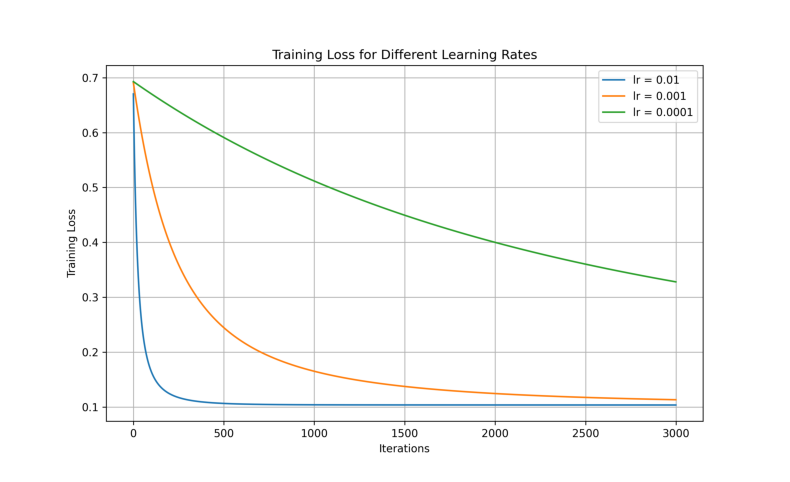

In [30]:
plot_filename = "lr_experiment.png"
if os.path.exists(plot_filename):
    print(f"Plot '{plot_filename}' already exists. Displaying saved plot:")
    # Load the image from file and display it
    img = plt.imread(plot_filename)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()
else:
    learning_rates = [0.01, 0.001, 0.0001]
    lr_experiment_results = {}
    num_iterations = 3000

    for lr in learning_rates:
        _, loss = logistic_regression_train(X_train, y_train, learning_rate=lr, num_iterations=num_iterations)
        lr_experiment_results[lr] = loss

    # Plot training loss with iterations
    plt.figure(figsize=(10, 6))
    for lr, loss_history in lr_experiment_results.items():
        plt.plot(range(num_iterations), loss_history, label=f'lr = {lr}')

    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different Learning Rates')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    plt.savefig(plot_filename, dpi=300)
    plt.show()

In [31]:
# 1. Train Logistic Regression
weights_lr, loss_history_lr = logistic_regression_train(
    X_train, y_train, 
    learning_rate=0.01, 
    num_iterations=3000
)

# 2. Build Validation Feature Matrix
validation_data_sorted = validation_data.sort_values('qid')
X_valid_lr, y_valid_lr = build_feature_matrix(validation_data_sorted, 
                                             valid_query_embs, 
                                             valid_passage_embs)

# 3. Predict Scores (probabilities)
lr_raw_scores = X_valid_lr @ weights_lr
lr_probs = sigmoid(lr_raw_scores)

# 4. Create Ranking Dictionary for top-100
validation_data_sorted = validation_data_sorted.copy()
validation_data_sorted['lr_score'] = lr_probs

ranking_dict_lr = {}
for qid, group_df in validation_data_sorted.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['lr_score']))
    # Sort and truncate at top-100
    pid_scores_sorted = dict(sorted(pid_scores.items(), 
                                    key=lambda x: x[1], 
                                    reverse=True)[:100])
    ranking_dict_lr[qid] = pid_scores_sorted

# 5. Evaluate using mean_AP and mean_NDCG
mAP_lr, AP_lr = mean_AP(ranking_dict_lr)
mNDCG_lr, NDCG_lr = mean_NDCG(ranking_dict_lr)

print("Logistic Regression (cutoff=100):")
print("mAP:", mAP_lr)
print("mNDCG:", mNDCG_lr)

Logistic Regression (cutoff=100):
mAP: 0.008647071369628893
mNDCG: 0.02986902103150239


## Apply LR on "candidate_passages_top1000.tsv"

In [32]:
# Load test queries with explicit column names
test_queries = pd.read_csv('test-queries.tsv', sep='\t', header=None, names=['qid', 'query'])
# Load candidate passages with explicit column names (format: qid, pid, query, passage)
candidates = pd.read_csv('candidate_passages_top1000.tsv', sep='\t', header=None, 
                         names=['qid', 'pid', 'query', 'passage'])

In [33]:
# ------------------- Preprocessing -------------------
# Preprocess test queries
test_queries['clean_query'] = test_queries['query'].apply(lambda x: preprocess_text(x))
# Preprocess candidate passages: we need both the candidate "query" and "passage" fields
candidates['clean_query'] = candidates['query'].apply(lambda x: preprocess_text(x))
candidates['clean_passage'] = candidates['passage'].apply(lambda x: preprocess_text(x))
# Add a dummy relevancy column (not used for scoring, but required by build_feature_matrix)
candidates['relevancy'] = 0

In [34]:
# Build dictionaries for test queries and candidate passages
qid_query_test = dict(zip(test_queries.qid, test_queries['clean_query']))
pid_passage_test = dict(zip(candidates.pid, candidates['clean_passage']))

# Compute embeddings for test queries and candidate passages using your pre-trained Word2Vec model
test_query_embs = compute_embeddings(qid_query_test, word2vec_model)
test_passage_embs = compute_embeddings(pid_passage_test, word2vec_model)

## "LR.txt"

In [35]:
# Build feature matrix for LR model (concatenation of query and passage embeddings)
X_test_lr, _ = build_feature_matrix(candidates, test_query_embs, test_passage_embs)
# Compute LR raw scores using your trained logistic regression weights and apply the sigmoid function
candidates['lr_score'] = sigmoid(np.dot(X_test_lr, weights_lr))

# Build ranking dictionary for LR
ranking_dict_lr_test = {}
for qid, group_df in candidates.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['lr_score']))
    # Sort by descending score and keep the top 100 passages
    pid_scores_sorted = dict(sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    ranking_dict_lr_test[qid] = pid_scores_sorted

# Write LR submission file (LR.txt)
with open('LR.txt', 'w') as f:
    for qid in sorted(ranking_dict_lr_test.keys()):
        pid_scores = ranking_dict_lr_test[qid]
        sorted_items = sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)
        for rank, (pid, score) in enumerate(sorted_items, start=1):
            f.write(f"{qid} A2 {pid} {rank} {score} LR\n")

# Task 3: LambdaMART Model (LM)

## Construct 3-Dimensional Feature Vectors

In [36]:
def compute_3d_features(q_emb, p_emb):
    """
    Given a query embedding (q_emb) and passage embedding (p_emb),
    return a 3-dimensional feature vector:
      [ dot_product, norm(q_emb), norm(p_emb) ].
    """
    dot_prod = np.dot(q_emb, p_emb)
    q_norm = norm(q_emb)
    p_norm = norm(p_emb)
    return np.array([dot_prod, q_norm, p_norm])

def build_3d_feature_matrix(df, query_emb_dict, passage_emb_dict):
    """
    For each row (qid, pid) in df, compute the 3D feature vector.
    Return X (features), y (labels), and a parallel list of qids for grouping.
    """
    X_list = []
    y_list = []
    qid_list = []

    for idx, row in df.iterrows():
        qid = row['qid']
        pid = row['pid']
        relevancy = row['relevancy']
        
        # Retrieve embeddings
        q_emb = query_emb_dict[qid]
        p_emb = passage_emb_dict[pid]
        
        # Build 3D features
        features_3d = compute_3d_features(q_emb, p_emb)
        
        X_list.append(features_3d)
        y_list.append(relevancy)
        qid_list.append(qid)

    X = np.vstack(X_list)
    y = np.array(y_list)
    return X, y, qid_list

## Define Group qid and Grid Search

In [37]:
def group_by_qid(qid_array):
    """
    Convert a sorted array of qids into a list of group sizes.
    E.g., qid_array=[1,1,1,2,2,3,3,3] => group=[3,2,3].
    """
    group_sizes = []
    current_qid = qid_array[0]
    count = 0
    for qid in qid_array:
        if qid == current_qid:
            count += 1
        else:
            group_sizes.append(count)
            current_qid = qid
            count = 1
    group_sizes.append(count)
    return group_sizes

## Define 5-Fold Cross-Validation

In [38]:
def cross_validate_lambdamart(X, y, qids, param, n_splits=5):
    """
    Perform a custom 5-fold cross-validation for ranking.
    param: dict of XGBoost hyperparameters.
    Returns average validation NDCG (or mAP) across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    # We must split by queries in a robust way. For demonstration,
    # we are simply splitting by indices, but ideally you'd group
    # by qid to ensure queries are not split across folds.
    for train_index, valid_index in kf.split(X):
        X_train_cv, X_valid_cv = X[train_index], X[valid_index]
        y_train_cv, y_valid_cv = y[train_index], y[valid_index]
        qid_train_cv = np.array(qids)[train_index]
        qid_valid_cv = np.array(qids)[valid_index]

        # Sort by qid for grouping
        train_sort_idx = np.argsort(qid_train_cv, kind='stable')
        valid_sort_idx = np.argsort(qid_valid_cv, kind='stable')

        X_train_cv = X_train_cv[train_sort_idx]
        y_train_cv = y_train_cv[train_sort_idx]
        qid_train_cv = qid_train_cv[train_sort_idx]

        X_valid_cv = X_valid_cv[valid_sort_idx]
        y_valid_cv = y_valid_cv[valid_sort_idx]
        qid_valid_cv = qid_valid_cv[valid_sort_idx]

        # Create group info
        group_train_cv = group_by_qid(qid_train_cv)
        group_valid_cv = group_by_qid(qid_valid_cv)

        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dtrain.set_group(group_train_cv)
        dvalid = xgb.DMatrix(X_valid_cv, label=y_valid_cv)
        dvalid.set_group(group_valid_cv)

        # Train
        evallist = [(dtrain, 'train'), (dvalid, 'eval')]
        bst = xgb.train(param, dtrain, num_boost_round=10, evals=evallist, 
                        early_stopping_rounds=10, verbose_eval=False)
        
        # Evaluate on this fold: we can use the final NDCG from the last iteration
        # XGBoost automatically tracks 'eval' NDCG. Let's fetch bst.best_score:
        fold_metric = bst.best_score
        metrics.append(fold_metric)

    return np.mean(metrics)

## Build training features

In [39]:
train_data_sorted = train_data_subsampled.sort_values('qid')
X_train_3d, y_train_3d, qids_train = build_3d_feature_matrix(
    train_data_sorted,
    query_emb_dict=train_query_embs,
    passage_emb_dict=train_passage_embs
)

## Standardize

In [40]:
scaler = StandardScaler()
X_train_3d = scaler.fit_transform(X_train_3d)

## Sort by qid for the full training set

In [41]:
sort_idx = np.argsort(qids_train, kind='stable')

X_train_3d_sorted = X_train_3d[sort_idx]
y_train_3d_sorted = y_train_3d[sort_idx]

qids_train = np.array(qids_train)
qids_train_sorted = qids_train[sort_idx]

group_train = group_by_qid(qids_train_sorted)

## Create a DMatrix for the entire training set

In [42]:
dtrain_full = xgb.DMatrix(X_train_3d_sorted, label=y_train_3d_sorted)
dtrain_full.set_group(group_train)

## Define hyperparameter grid

In [43]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],        # learning rate
    'max_depth': [3, 4, 5],         # tree depth
    'min_child_weight': [1, 2],     # min hessian sum in child
    'reg_lambda': [0, 0.05, 0.1],   # L2 regularization strength
    'subsample': [0.7, 0.85, 1.0],  # row sampling
    # etc. if you like (colsample_bytree, gamma, etc.)
}

best_score = -1
best_params = None

## Grid search with cross-validation

In [81]:
# Initialize a counter for the number of iterations
iteration_count = 0

# Iterate over the parameter grid
for candidate_params in ParameterGrid(param_grid):
    # Increment the counter for each iteration
    iteration_count += 1
    
    candidate_params['objective'] = 'rank:ndcg'      # LambdaMART
    candidate_params['eval_metric'] = ['ndcg']      # track NDCG & MAP in logs

    print("Testing:", candidate_params)
    score = cross_validate_lambdamart(
        X_train_3d_sorted,
        y_train_3d_sorted,
        qids_train_sorted,
        candidate_params,
        n_splits=5
    )
    print("CV Score (NDCG):", score)

    if score > best_score:
        best_score = score
        best_params = candidate_params

# Print the total number of iterations, best parameters, and best CV score
print("\nTotal Iterations:", iteration_count)
print("Best Params:", best_params)
print("Best CV NDCG:", best_score)

Testing: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'subsample': 0.7, 'objective': 'rank:ndcg', 'eval_metric': ['ndcg']}
CV Score (NDCG): 0.9242867072557267
Testing: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'subsample': 0.85, 'objective': 'rank:ndcg', 'eval_metric': ['ndcg']}
CV Score (NDCG): 0.9234582674000326
Testing: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0, 'subsample': 1.0, 'objective': 'rank:ndcg', 'eval_metric': ['ndcg']}
CV Score (NDCG): 0.9234510218259189
Testing: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0.05, 'subsample': 0.7, 'objective': 'rank:ndcg', 'eval_metric': ['ndcg']}
CV Score (NDCG): 0.9242925432153243
Testing: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 0.05, 'subsample': 0.85, 'objective': 'rank:ndcg', 'eval_metric': ['ndcg']}
CV Score (NDCG): 0.9234590615536569
Testing: {'learning_ra

## Train final model with best parameters

In [45]:
eval_list = [(dtrain_full, 'train')]
bst_final = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=300,
    evals=eval_list,
    early_stopping_rounds=10
)
print("Finished training final model with best hyperparams.")

[0]	train-ndcg:0.33885
[1]	train-ndcg:0.37628
[2]	train-ndcg:0.41774
[3]	train-ndcg:0.43223
[4]	train-ndcg:0.44381
[5]	train-ndcg:0.45426
[6]	train-ndcg:0.46220
[7]	train-ndcg:0.46510
[8]	train-ndcg:0.46555
[9]	train-ndcg:0.47125
[10]	train-ndcg:0.47313
[11]	train-ndcg:0.47559
[12]	train-ndcg:0.47821
[13]	train-ndcg:0.48033
[14]	train-ndcg:0.48271
[15]	train-ndcg:0.48682
[16]	train-ndcg:0.48690
[17]	train-ndcg:0.48882
[18]	train-ndcg:0.49035
[19]	train-ndcg:0.49153
[20]	train-ndcg:0.49189
[21]	train-ndcg:0.49302
[22]	train-ndcg:0.49277
[23]	train-ndcg:0.49415
[24]	train-ndcg:0.49561
[25]	train-ndcg:0.49555
[26]	train-ndcg:0.49639
[27]	train-ndcg:0.49535
[28]	train-ndcg:0.49616
[29]	train-ndcg:0.49860
[30]	train-ndcg:0.49899
[31]	train-ndcg:0.49894
[32]	train-ndcg:0.49944
[33]	train-ndcg:0.50178
[34]	train-ndcg:0.50106
[35]	train-ndcg:0.50207
[36]	train-ndcg:0.50197
[37]	train-ndcg:0.50411
[38]	train-ndcg:0.50372
[39]	train-ndcg:0.50541
[40]	train-ndcg:0.50682
[41]	train-ndcg:0.50719
[4

## Evaluate on Validation

In [46]:
X_valid_3d, y_valid_3d, qids_valid = build_3d_feature_matrix(
    validation_data,
    query_emb_dict=valid_query_embs,
    passage_emb_dict=valid_passage_embs
)

## Transform validation to scalar

In [47]:
X_valid_3d = scaler.transform(X_valid_3d)

## Sort by qid

In [48]:
sort_idx_val = np.argsort(qids_valid, kind='stable')
X_valid_3d_sorted = X_valid_3d[sort_idx_val]
y_valid_3d_sorted = y_valid_3d[sort_idx_val]

qids_valid = np.array(qids_valid)
qids_valid_sorted = qids_valid[sort_idx_val]

group_valid = group_by_qid(qids_valid_sorted)

## Create DMatrix for validation

In [49]:
dvalid = xgb.DMatrix(X_valid_3d_sorted, label=y_valid_3d_sorted)
dvalid.set_group(group_valid)

## Predict on validation

In [50]:
preds = bst_final.predict(dvalid)

## Attach scores to validation DataFrame for ranking

In [51]:
validation_data_sorted = validation_data.copy()
validation_data_sorted = validation_data_sorted.iloc[sort_idx_val].reset_index(drop=True)
validation_data_sorted['score'] = preds

## Build ranking dict

In [52]:
ranking_dict_lm = {}
for qid, group_df in validation_data_sorted.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['score']))
    pid_scores_sorted = dict(sorted(pid_scores.items(), 
                                    key=lambda x: x[1], 
                                    reverse=True)[:100])
    ranking_dict_lm[qid] = pid_scores_sorted

## Evaluate using mAP and mNDCG

In [53]:
mAP_lm, _ = mean_AP(ranking_dict_lm)
mNDCG_lm, _ = mean_NDCG(ranking_dict_lm)

print("LambdaMART (3D features) - final model - mAP:", mAP_lm)
print("LambdaMART (3D features) - final model - mNDCG:", mNDCG_lm)

LambdaMART (3D features) - final model - mAP: 0.06292713332127359
LambdaMART (3D features) - final model - mNDCG: 0.11581333251204133


## Apply LM on "candidate_passages_top1000.tsv"

In [54]:
# Build 3D feature matrix for LM model using the test embeddings
X_test_3d, _, _ = build_3d_feature_matrix(candidates, test_query_embs, test_passage_embs)
# Standardize using the same scaler from training
X_test_3d = scaler.transform(X_test_3d)
# Create a DMatrix and predict LM scores using your final XGBoost model (bst_final)
dtest = xgb.DMatrix(X_test_3d)
lm_scores = bst_final.predict(dtest)
candidates['lm_score'] = lm_scores

In [55]:
# Build ranking dictionary for LM
ranking_dict_lm_test = {}
for qid, group_df in candidates.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['lm_score']))
    pid_scores_sorted = dict(sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    ranking_dict_lm_test[qid] = pid_scores_sorted

## "LM.txt"

In [56]:
# Write LM submission file (LM.txt)
with open('LM.txt', 'w') as f:
    for qid in sorted(ranking_dict_lm_test.keys()):
        pid_scores = ranking_dict_lm_test[qid]
        sorted_items = sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)
        for rank, (pid, score) in enumerate(sorted_items, start=1):
            f.write(f"{qid} A2 {pid} {rank} {score} LM\n")

# Task 4: Neural Network Model (NN).

## Define a PyTorch Dataset for our training data

In [58]:
class PassageDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # binary labels: 0 or 1
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Define a class "NNmodel": a simple feed-forward network with two hidden layers

In [109]:
class NNModel(nn.Module):
    def __init__(self, input_dim):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Define a training loop for our NN model

In [84]:
def train_nn(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)  # shape: (batch_size, 1)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return loss_history

## Build the training feature matrix

In [64]:
X_train_nn, y_train_nn = build_feature_matrix(train_data_subsampled, train_query_embs, train_passage_embs)

## Create a Dataset and DataLoader for training

In [104]:
batch_size = 512
train_dataset = PassageDataset(X_train_nn, y_train_nn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Set up device, instantiate the NN model, loss function and optimizer

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_nn.shape[1]  # e.g. 200 (if each embedding is 100-dimensional)
model_nn = NNModel(input_dim).to(device)
criterion = torch.nn.BCEWithLogitsLoss()  # internally applies sigmoid
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.0001, weight_decay=4e-4)
num_epochs = 100

## Train the Neural Network

In [110]:
loss_history_nn = train_nn(model_nn, train_loader, criterion, optimizer, num_epochs, device)

Epoch 10/100, Loss: 0.0890
Epoch 20/100, Loss: 0.0879
Epoch 30/100, Loss: 0.0866
Epoch 40/100, Loss: 0.0852
Epoch 50/100, Loss: 0.0834
Epoch 60/100, Loss: 0.0828
Epoch 70/100, Loss: 0.0817
Epoch 80/100, Loss: 0.0807
Epoch 90/100, Loss: 0.0801
Epoch 100/100, Loss: 0.0794


## Plot training loss over epochs

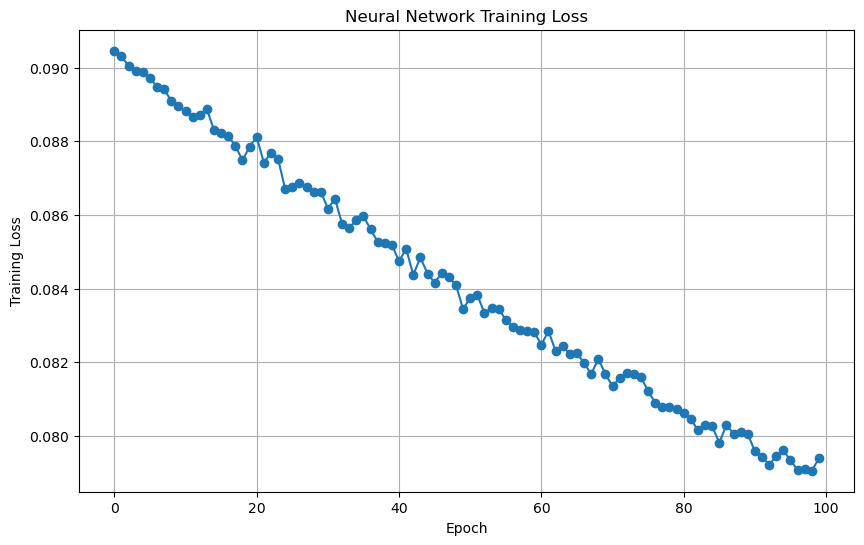

In [111]:
plt.figure(figsize=(10,6))
plt.plot(range(num_epochs), loss_history_nn, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Neural Network Training Loss')
plt.grid(True)
plt.show()

## Evaluate the Model on the Validation Set

In [112]:
validation_data_sorted = validation_data.sort_values('qid').reset_index(drop=True)
X_valid_nn, y_valid_nn = build_feature_matrix(validation_data_sorted, 
                                             valid_query_embs,  # from Task 2
                                             valid_passage_embs)  # from Task 2

model_nn.eval()
with torch.no_grad():
    X_valid_tensor = torch.tensor(X_valid_nn, dtype=torch.float32).to(device)
    outputs = model_nn(X_valid_tensor)
    nn_scores = torch.sigmoid(outputs).squeeze().cpu().numpy()

# Attach the NN scores to the validation DataFrame
validation_data_sorted['nn_score'] = nn_scores

# Build a ranking dictionary for validation
ranking_dict_nn_val = {}
for qid, group_df in validation_data_sorted.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['nn_score']))
    # Sort by descending score, keep top-100
    pid_scores_sorted = dict(sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    ranking_dict_nn_val[qid] = pid_scores_sorted

## Evaluate using mean_AP and mean_NDCG

In [113]:
mAP_nn, _ = mean_AP(ranking_dict_nn_val)
mNDCG_nn, _ = mean_NDCG(ranking_dict_nn_val)

print("Neural Network Model (Validation) - mAP:", mAP_nn)
print("Neural Network Model (Validation) - mNDCG:", mNDCG_nn)

Neural Network Model (Validation) - mAP: 0.05249864513941849
Neural Network Model (Validation) - mNDCG: 0.12180484207367016


## Apply NN on "candidate_passages_top1000.tsv"

In [114]:
# Build the Feature Matrix for NN (concatenated query+passage embeddings)
X_test_nn, _ = build_feature_matrix(candidates, test_query_embs, test_passage_embs)

# Predict Scores with the Trained Neural Network
model_nn.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32).to(device)
    nn_outputs = model_nn(X_test_tensor)
    nn_scores = torch.sigmoid(nn_outputs).squeeze().cpu().numpy()
candidates['nn_score'] = nn_scores

# Build Ranking Dictionary for Each Query (top 100)
ranking_dict_nn_test = {}
for qid, group_df in candidates.groupby('qid'):
    pid_scores = dict(zip(group_df['pid'], group_df['nn_score']))
    pid_scores_sorted = dict(sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)[:100])
    ranking_dict_nn_test[qid] = pid_scores_sorted

## "NN.txt"

In [80]:
with open('NN.txt', 'w') as f:
    for qid in sorted(ranking_dict_nn_test.keys()):
        pid_scores = ranking_dict_nn_test[qid]
        sorted_items = sorted(pid_scores.items(), key=lambda x: x[1], reverse=True)
        for rank, (pid, score) in enumerate(sorted_items, start=1):
            # Format: qid, "A2", pid, rank, score, "NN"
            f.write(f"{qid} A2 {pid} {rank} {score} NN\n")

print("Submission file 'NN.txt' generated successfully!")

Submission file 'NN.txt' generated successfully!
